# Exercise 1
Note: This exercise closely follows the post by Scott Fortmann-Roe about bias-variance tradeoff (see references below). It is recommended that you think about each of the questions before referring to that essay.

In this exercise you will get familiar with a **non-parapmetric** learning algorithm called k-Nearest Neighbours (kNN), and will implement it. You will then analyse the bias-variance tradeoff and try to come up with the optimal kNN classifier for the given data.

For this exercise we will use hypothetical and artificial generated data.


## Implement k-Nearest Neighbours (kNN)

The kNN algorithm is simple - given a labeled sample set data, and a new sample, predict the label of this sample by using majority vote (or averaging) over the labels of the k-nearest neighbour of the new data in the sample set.

For this task, assume each data point is an n-dimensional point in $\mathbb{R}^n$, and each label is either 0 or 1.

Implement a class called KNNClassifier and two methods:
- `fit`: should recieve the training data (an array of shape [n_samples, n_features]) and their labels (array of shape [n_samples]). 
- `predict`: should recieve a set of data (an array of shape [n_samples, n_features]) and **return** their predicted labels (array of shape [n_samples]).

Use simple Euclidean distance to measure the distance between two points. In case two points in the training have the same distance from a given point to predict, the nearest would be the one appearing first in the training set. 

Use majority vote between all kNN of a point to predict its label. In case the vote of all kNN is tied, you may predict whichever label you wish.

You may look up [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for reference.



In [1]:
import math

class kNNClassifier:
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors
    def fit(self, X, y):
        self.X, self.y = X, y
    
    def distance(self, x1, x2):
        return math.sqrt(sum([(x1[d]-x2[d])**2 for d in range(len(x1))]))
    
    def distance_list(self, x1):
        # save index, distance of all neighbours
        return [(idx, self.distance(x1, x2)) for idx, x2 in enumerate(self.X)]
    
    def n_neighbour_list(self, x1):
        dist_list = self.distance_list(x1)
        # sort by value, not index
        dist_list.sort(key=(lambda x: x[1]))
        
        return dist_list[:self.n_neighbors]
    
    def predict_one_value(self, x1):
        neighbours = self.n_neighbour_list(x1)
        vote = sum([self.y[n[0]] for n in neighbours]) / self.n_neighbors
        
        # if the vote is a draw, take the value of the nearest neighbour
        return round(vote)
    
    def predict(self, X):
        return [self.predict_one_value(x_i) for x_i in X]
    
    def score(self, df_test, y_test):
        predictions = self.predict(df_test)
        return np.sum(np.array(predictions) == np.array(y_test)) / len(predictions)

## Learn and evaluate kNN algorithm on artificial data
kNN is a **non-parametric** in the sense that no inner parameter of the model is learned by the sample training set (or maybe you could say that the number of parameters increases with the size of the sample set). However, the number of neighbours **k is considered a hyper-parameter**, and choosing the optimal value for it, is choosing the balance between bias and variance as discussed in class.




### An applied example: voter party registration

In this example, each voter is described by a vector of two features $(x_0, x_1)$, where $x_0$ describes how wealthy that voter is, and $x_1$ describes how religious the voter is. Label $y=1$ represents a Republican voter, and $y=-1$ represents a Democrat voter.

Use the given function `generate_data(m)` to create m samples with m labels. The labels are created using the following function:

$$
y = \text{sign}\left(x_1 - 0.1\times((x_0-5)^3-x_0^2+(x_0 − 6)^2+80)\right)
$$

and then a small fraction of the labels (chosen randomly, up to 10%) are flipped to represent unknown effect of features which are not measured. The sign of 0 is defined as 1 for this case.


Below is an example of generating 500 samples, and plotting them.

In [11]:
import numpy as np
import pandas as pd
from numpy import array

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import figure

from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

def true_boundary_voting_pred(wealth, religiousness):
    return religiousness-0.1*((wealth-5)**3-wealth**2+(wealth-6)**2+80)

def generate_data(m, n=2, seed=None):
    # if seed is not None, this function will always generate the same data
    np.random.seed(seed) 

    X = np.random.uniform(low=0.0, high=10.0, size=(m,n))
    y = np.sign(true_boundary_voting_pred(X[:,0], X[:,1]))
    y[y==0] = 1
    samples_to_flip = np.random.randint(0,m//10)
    flip_ind = np.random.choice(m, samples_to_flip, replace=False)
    y[flip_ind] = -y[flip_ind]
    return X, y

def plot_labeled_data(X, y, no_titles=False):
    republicans = (y==1)
    democrats = (y==-1)

    plt.scatter(X[republicans,0], X[republicans,1], c='r')
    plt.scatter(X[democrats,0], X[democrats,1], c='b')
    if not no_titles:
        plt.xlabel('Wealth')
        plt.ylabel('Religiousness')
        plt.title('Red circles represent Republicans, Blues Democrats')

    plt.xlim([0, 10]);
    plt.ylim([0, 10]);
    plt.plot(np.linspace(0,10,1000), -true_boundary_voting_pred(np.linspace(0,10,1000), np.zeros(1000)), linewidth=2, c='k');


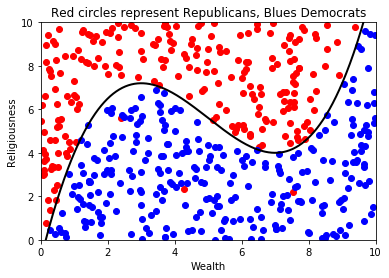

In [13]:
# Play this several times to see different sampling sets
X, y = generate_data(500, 2)

plot_labeled_data(X, y)


### 1. Analyse the properties of kNN
Generate multiple sample data sets of size 500 (use the given function above), and plot the decision plane for increasing values of k (e.g.: 1, 3, 5, 11, 21, 51, 99).

The decision plane should cover the range [0,10] for both axes, coloring the patches that would be classified as Republicans or Democrats in two colors. It should look something like [that](https://drive.google.com/open?id=1jMD7I9sWT4w4O48pjwSPCFL1NLLPo10j).

Answer the following questions:
- How is the decision plain affected from changes in the sample set, as a function of k?
- Can you describe when do you underfit or overfit the data? 
- How does the complexity of this model depends on k?

In [9]:
custom_cmap = ListedColormap(['#00bfff', '#ff0000'], name='from_list', N=None)

def model_boundary_voting_pred(model):
    # init X
    X = np.mgrid[0:10:10j, 0:10:21j].reshape(2,-1).T
    y = model.predict(X)

    boundary = np.zeros(10)
    
    for idx in range(len(boundary)):
        boundary[idx] = 9.75 - np.asarray(y[21*idx:21*idx+20]).mean()*10
        
    return boundary

def plot_decision_plane(model, title='Red hexagons represent Republicans, Blues Democrats'):
    # init X
    X = np.mgrid[0:10:35j, 0:10:21j].reshape(2,-1).T
    
    # predict y with model
    y = np.asarray([1.0 if v == 1 else -1.0 for v in model.predict(X)])
    republicans = (y==1)
    democrats = (y==-1)

    # plot the values
    plt.hexbin(X[:,0], X[:,1], y, gridsize=(17,10), edgecolors='black', bins=2, cmap=custom_cmap, linewidths=0.5)

    #if not no_titles:
    plt.xlabel('Wealth')
    plt.ylabel('Religiousness')
    plt.title(title)

    plt.xlim([0, 10]);
    plt.ylim([0, 10]);
    
    # Use cubic spline interpolation to smooth the bounary line a tad
    f1 = interp1d(np.linspace(0,10,10), model_boundary_voting_pred(model),kind='cubic')
    df_boundary = pd.DataFrame()
    new_index = np.linspace(0,10,100)
    df_boundary['boundary'] = f1(new_index)
    df_boundary.index = new_index

    plt.plot(new_index, df_boundary['boundary'], linewidth=3, c='k', linestyle='--');

Red hexagons represent Republicans, Blue Democrats


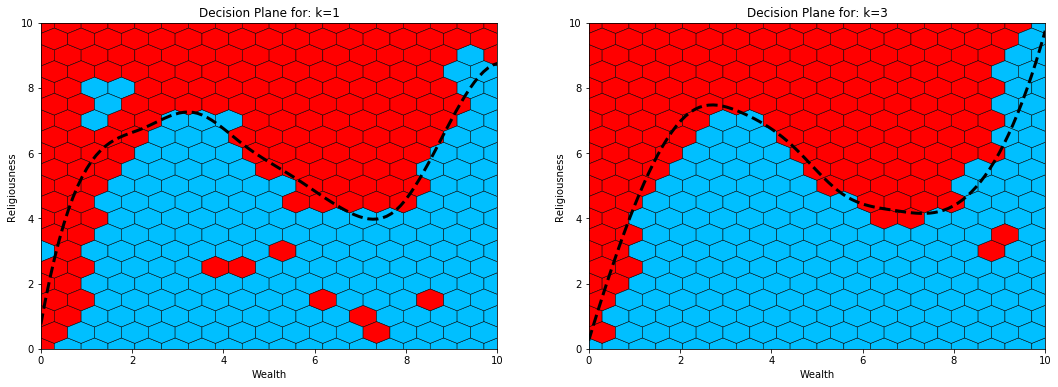

Red hexagons represent Republicans, Blue Democrats


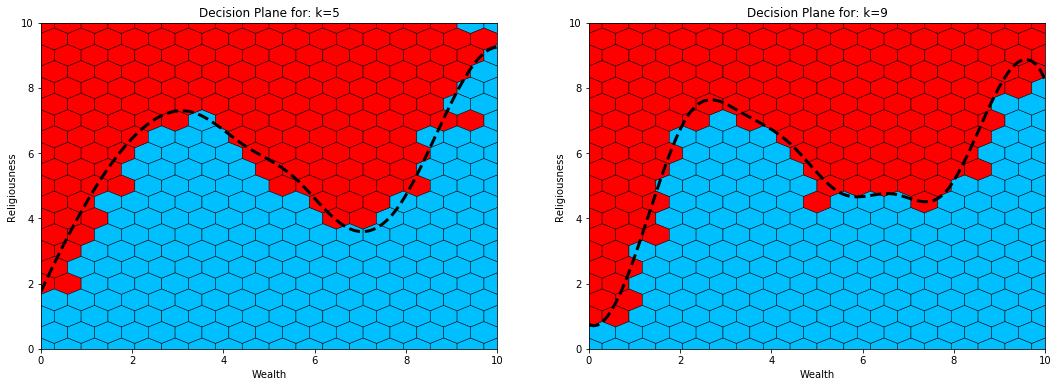

Red hexagons represent Republicans, Blue Democrats


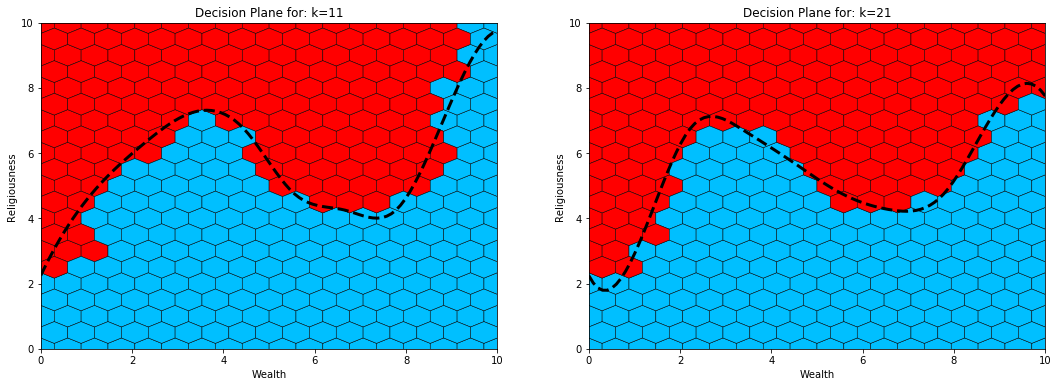

Red hexagons represent Republicans, Blue Democrats


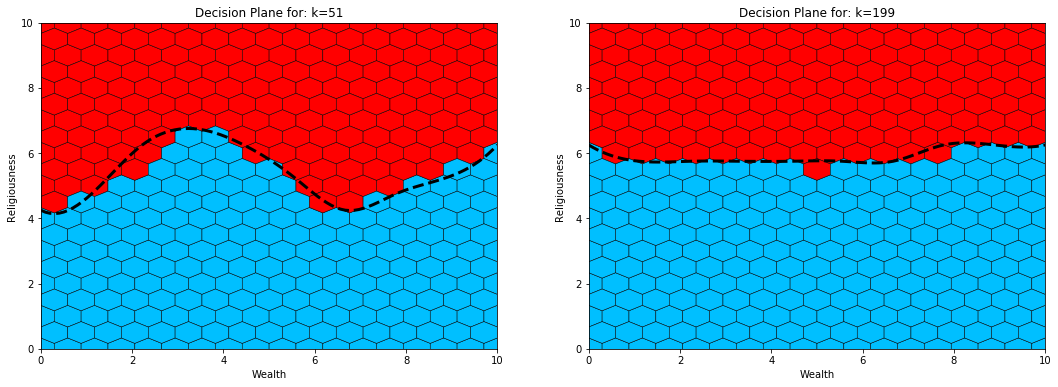

In [10]:
k_values = [1, 3, 5, 9, 11, 21, 51, 199]

for idx, k in enumerate(k_values):
    X, y = generate_data(500, 2)
    
    if idx%2 == 0:
        plt.subplots(1,2, figsize=(18, 6))
    
    # Normalize the votes to be 0 or 1
    y_norm = [int(v) if v == 1 else 0 for v in y]

    model = kNNClassifier(k)
    model.fit(X, y_norm)
        
    # Males
    plt.subplot(1, 2, idx%2+1)
    plot_decision_plane(model, 'Decision Plane for: k=%s' % k)
    
    if idx%2 == 1:
        print('Red hexagons represent Republicans, Blue Democrats')
        plt.show()

How is the decision plane affected from changes in the sample set, as a function of k?
-  for very small values of k (<=3), the predictions are affected by the flipped votes
-  for higher number of neighbors these outliers are evened out

Can you describe when do you underfit or overfit the data?
-  the smaller the k, the more the model is overfitted as explained above. A balanced model should not predict outling values. On the other hand, high values of k underfit the data, because values in the bottom left, and upper right corners have more neighbors of the opposite side.

How does the complexity of this model depends on k?
-  in this model, the complexity is negatively correlated to the number of neighbors considered. Very small k yield very complex decision planes

### 2. Finding the optimal k
Sample a single sample set of size 1000 and divide it randomly to train (0.6) / validation (0.2) / test (0.2) sets. Plot the train vs validation error for several k values, and choose the best k. Where do you underfit/overfit the data? Finally, estimate the generalization error of your chosen classifier using the test set.


Validation error for the various k's:
(1, 8.50%) (3, 8.50%) (5, 7.50%) (7, 6.50%) (9, 9.00%) (15, 7.50%) (51, 11.00%) (99, 13.00%)


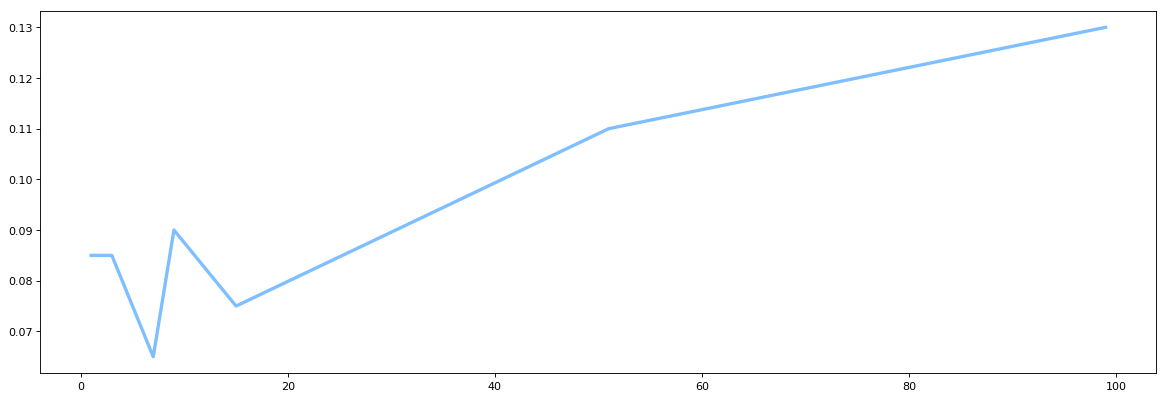

In [6]:
X, y = generate_data(1000, 2)
y_norm = np.array([int(v) if v == 1 else 0 for v in y])

# Let's now remove the boat and rerun the model
# Let's prepare our training and test datasets
df_train_val, df_test, y_train_val, y_test = train_test_split(X, y_norm, test_size=0.2)
df_train, df_val, y_train, y_val = train_test_split(df_train_val, y_train_val, test_size=0.25)

figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')

k_values = [1,3,5,7,9,15,51,99]
validation_error = []
for k in k_values:
    clf = kNNClassifier(k)

    # Create a list of the feature column's names
    clf.fit(df_train, y_train)

    # Compute prediction accuracy
    score = clf.score(df_val, y_val)
    validation_error.append(1-score)

plt.plot(k_values, validation_error, linewidth=3, c='#0080ff', alpha=0.5);
print("Validation error for the various k's:\n%s" % ' '.join(['(%d, %.2f%%)' % (k_values[i], validation_error[i]*100) for i in range(0, len(k_values))]))

We choose the value of k = 3 because it offers the lowest rate of error. If we choose a value above 7 we will start underfitting and if we choose a value below 3 we will overfit.

In [7]:
# Create again the model with 5 neighbours
clf = kNNClassifier(5)

# Train it against train + validation
clf.fit(df_train_val, y_train_val)

# Finally evaluate the generalization error
score = clf.score(df_test, y_test)
print('The generalization error is %.2f%%' % ((1-score)*100))

The generalization error is 6.00%


The generalization error is not very close to the validation error, and surprisingly it is higher, where we would expect a larger training set to provide more accuracy. This highlights the need for an averaged approach like X-fold Cross Validation.

### 3. Using cross validation
This time, put the test data aside (0.2 of the data), and apply 5-fold CV on the remaining data to evaluate the performance of each k value. 
What is the size of the validation and train set now, in each CV iteration?
Did your final model selection change? Explain why.


Average validation error for the various k's:
(1, 8.88%) (3, 7.25%) (5, 7.25%) (7, 7.37%) (9, 7.13%) (15, 8.00%) (51, 11.50%) (99, 14.50%)


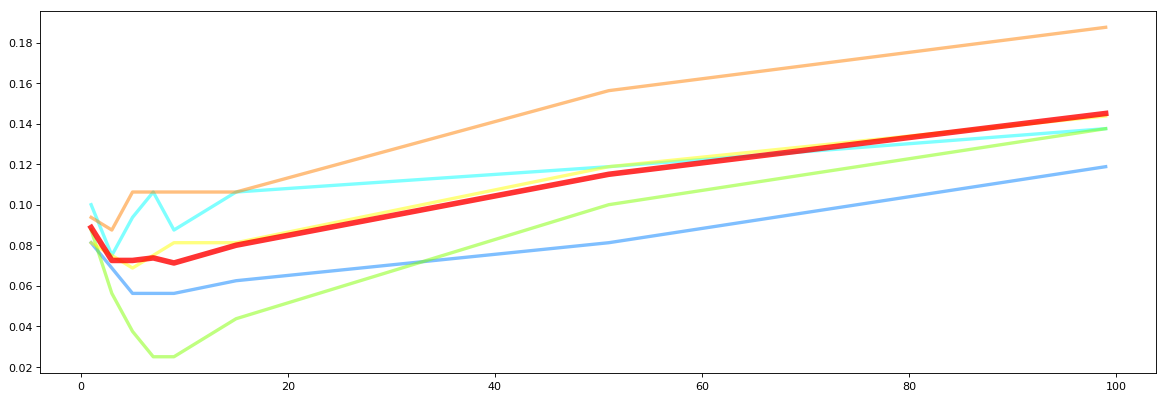

In [8]:
n_splits = 5
kf = KFold(n_splits=n_splits)
kf.get_n_splits(df_train_val)

# Init chart
figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
color_list = ['#0080ff', '#00ffff', '#80ff00', '#ffff00', '#ff8000']
i = 0
val_error_sum = [0]*len(k_values)
for train_index, val_index in kf.split(df_train_val):
    df_train, df_val = df_train_val[train_index], df_train_val[val_index]
    y_train, y_val = y_train_val[train_index], y_train_val[val_index]
    
    validation_error = []
    for k in k_values:
        clf = kNNClassifier(k)

        # Create a list of the feature column's names
        clf.fit(df_train, y_train)

        # Compute prediction accuracy
        score = clf.score(df_val, y_val)
        validation_error.append(1-score)
    
    plt.plot(k_values, validation_error, linewidth=3, c=color_list[i], alpha=0.5);
    val_error_sum = [val_error_sum[j] + validation_error[j] for j in range(len(val_error_sum))]
    i += 1

val_error_avg = [val_error_sum[j]/n_splits for j in range(len(val_error_sum))]
plt.plot(k_values, val_error_avg, linewidth=5, c='red', alpha=0.8);
print("\nAverage validation error for the various k's:\n%s" % ' '.join(['(%d, %.2f%%)' % (k_values[i], val_error_avg[i]*100) for i in range(0, len(k_values))]))

The red line in the chart above is the average of the 5 cross validation results. 

The KNN model with 7 neighbours yields slightly better results than the 3 and 5 neighbours models but not significatively. However, we can clearly see that any value below 3 or above 7 won't improve our model.

## References
- http://scott.fortmann-roe.com/docs/BiasVariance.html
- http://scott.fortmann-roe.com/docs/MeasuringError.html
- http://scikit-learn.org/stable/modules/cross_validation.html